<a href="https://colab.research.google.com/github/vitalns/pairplot/blob/main/pairplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
<h2> <font color='blue'>Построение парной диаграммы </font> </h2>
</div>

Примеры посторения парной диаграммы с помощью pairplot и pairgrid. Используется датасет penguins. На графики добавлены маркеры средних значений, анотации, легенда, ...

#*Построение парной диаграммы*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## *Предобработка данных*

In [3]:
# Загрузим датасет "Пингвины"

penguins = sns.load_dataset("penguins")
penguins.dropna(inplace=True)
penguins.reset_index(drop=True, inplace=True)

In [4]:
# Создадим таблицу со средними значениями.

species = penguins.species.unique()
# # Раньше и так отлично работало
# averages = [penguins[penguins['species']==i].mean().to_list() for i in species]
averages = [penguins[penguins['species']==i][penguins.select_dtypes(np.number).columns].mean().to_list() for i in species]
avg_data = pd.DataFrame(averages, columns=penguins.select_dtypes(np.number).columns)
avg_data['species'] = species
avg_data

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,38.823973,18.347260,190.102740,3706.164384,Adelie
1,48.833824,18.420588,195.823529,3733.088235,Chinstrap
2,47.568067,14.996639,217.235294,5092.436975,Gentoo


In [5]:
# Добавим средние значения характеристик к общей таблице.

avg = avg_data.copy(deep=True)
avg.species = 'mean' # Добавляем заглушку для hue в pairgrid.
penguins_avg = pd.concat([penguins, avg], ignore_index=True)
penguins_avg.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
331,Gentoo,Biscoe,45.200000,14.800000,212.000000,5200.000000,Female
332,Gentoo,Biscoe,49.900000,16.100000,213.000000,5400.000000,Male
333,mean,NaN,38.823973,18.347260,190.102740,3706.164384,NaN
334,mean,NaN,48.833824,18.420588,195.823529,3733.088235,NaN
335,mean,NaN,47.568067,14.996639,217.235294,5092.436975,NaN


##*Построение парной диаграммы с помощью* ***pairplot***.

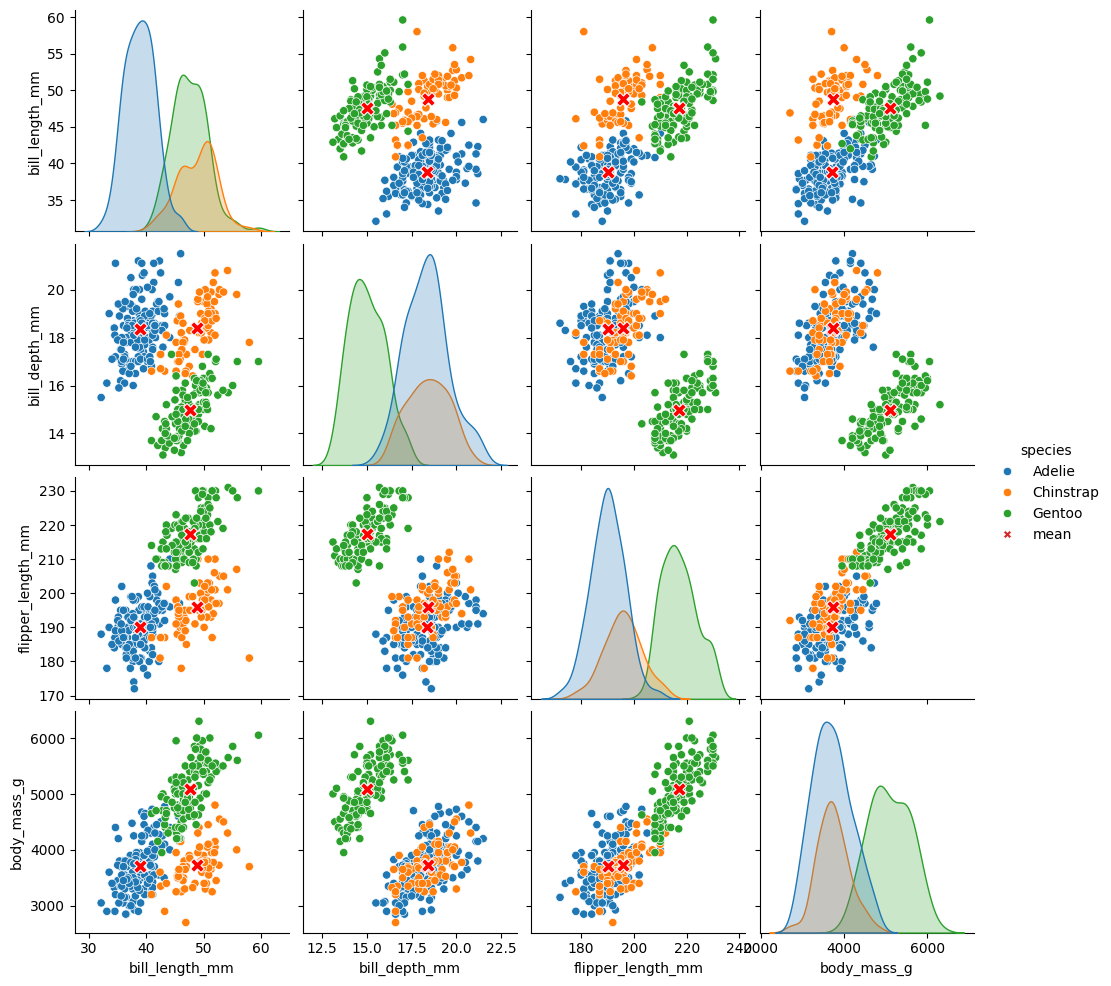

In [6]:
# Построим парную диаграмму с помощью pairplot и добавим средние значения на график.

g = sns.pairplot(data=penguins_avg,  # Используем датасет со средними значениями, чтобы маркер добавился на легенду
                 hue='species',
                 diag_kind='None', # На диагональ добавим графики отдельно без средних значений
                #  diag_kind='kde',  # по умолчанию
                 markers=['o', 'o', 'o', 'X'],
                #  palette='tab10',  # по умолчанию
                 )
# В легенде по умолчанию используется список созданных экземпляров из hue.
# g.add_legend(legend_data=g._legend_data)
# g._legend.remove()  # Убрать легенду можно используя метод remove

# Добавим на диагональные графики kdeplot, исключив средние значения.
g.map_diag(sns.kdeplot, fill=True,
           data=penguins, hue='species')

# Второй вариант отсеить среднее через функцию.
# def func(*args, **kwargs):
#   data = args[0]
#   if kwargs['label'] in g._hue_order[:3]:
#     sns.kdeplot(data, fill=True, alpha=0.3)
# g.map_diag(func)

# С помощью pairgrid настроим размер, цвет и тип маркера среднего значения.
g.data = avg
g.map_offdiag(func=sns.scatterplot,
              hue=None,  # Необходимо сбросить hue, чтобы маркеру среднего задать новые установки
              s=100, marker='X', color='r')

##*Построение парной диаграммы с помощью* ***pairgrid***.

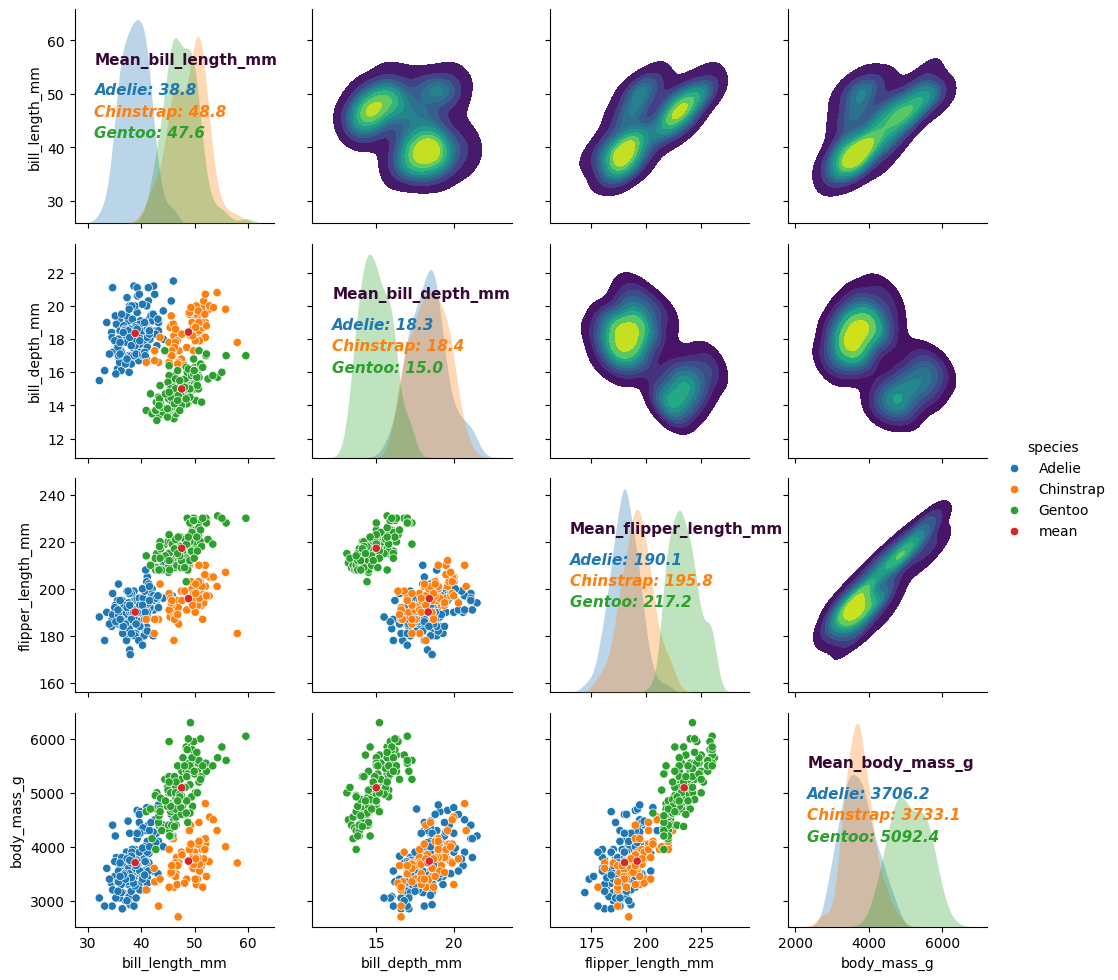

In [14]:
# Построим парную диаграмму с помощью pairgrid и добавим анотацию на диагональные графики.

# Создадим объект класса PairGrid.
g = sns.PairGrid(penguins_avg,  # Полный датасет с добавленным средними значениями (species="mean")
                 hue='species',
                 diag_sharey=False,  # Необходимое условие, чтобы диаграммы kde по диагонали масштабировались под ось Y.
                 palette='tab10'
                 )
# На нижних графиках оставим диаграммы рассеяния.
g.map_lower(sns.scatterplot)  # Функию можно задать plt.scatter, но у seaborn больше настроек.

g.add_legend()

# Добавим на диагональные элементы анотацию к среднимb значениямb.

# Не нашёл в seaborn аналог get_color() из plt, поэтому создал словарь с цветами в соответствии с hue_order.
cmap_hue = dict(zip(g._hue_order[:3], sns.color_palette('tab10')[:3]))

def annotate_func(*args, **kwargs):
  data = args[0]
  mean = data.mean()
  ax = plt.gca()
  # Каждое значения species из списка hue нужно записать с новой строки,
  # поэтому будем считать сколько экземпляров дочернего класса matplotlib.text.Annotation уже есть.
  # Можно считать экземпляры matplotlib.text.Text, но так как на графике уже есть подписи, то начальное значение не нулевое.
  n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
  pos = (.1, .6 - .1*n)
  if n == 0:  # Добавим заглавие фичи для которой вычесляем среднее
    ax.text(.1,.8,
            f"Mean_{args[0].name}",
            size=11, weight='black', stretch='condensed', color='xkcd:eggplant',
            va='top',  # По умолчанию ha='left' и va='bottom'
            transform=ax.transAxes
            )
  if kwargs['label'] in g._hue_order[:3]:  # Добавим анотацию для средних значений для всех species из фрейма кроме mean.
    sns.kdeplot(data, fill=True, linewidth=0, alpha=0.3)  # Добавить график без заливки в качестве фона.
    ax.annotate(f"{kwargs['label']}: {mean:.1f}",
                size=11, style='oblique', weight='bold',
                c=cmap_hue[kwargs['label']],
                xy=pos, xycoords=ax.transAxes
                )
g.map_diag(annotate_func)

# # На верхние графики добавим диаграммы "плотности", строим в последнюю очередь, так как сбрасываем hue.
g.map_upper(sns.kdeplot,
            fill=True, cmap='viridis',
            data=penguins, hue=None  # Используем данные без средних значений
            )

---

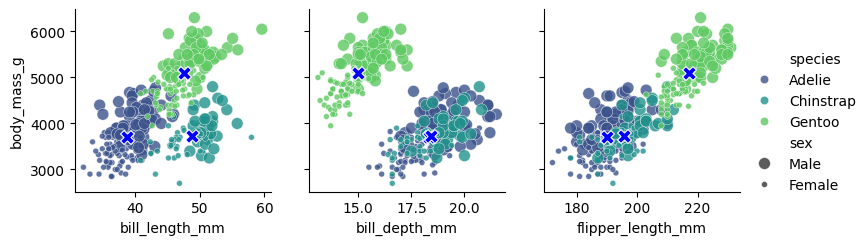

In [9]:
# Ещё пример построения парной диаграммы с pairgrid.

x_vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
y_vars = ['body_mass_g']
g = sns.PairGrid(penguins,
                 hue='species',
                 x_vars=x_vars,
                 y_vars=y_vars,
                 palette='viridis'
                 )
g.map_offdiag(sns.scatterplot,
              size=penguins.sex,
              alpha=0.8
              )

# Добавляем средние значения
avg = avg_data.copy(deep=True)
avg.species = 'mean'
g.data = avg
g.map_offdiag(func=sns.scatterplot, s=100, marker='X', hue=None, c='b')

g.add_legend(title='',
             adjust_subtitles=True  # Выравнивает текст на легенде
             )